In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from diffusion1ch import Unet, GaussianDiffusion, Trainer, Dataset, SimpleDataset
device = 'cuda:0'

import matplotlib.pyplot as plt
import torch

In [5]:
model = Unet(
    dim = 64,
    dim_mults = (1, 2, 2, 4, 4, 8, 8)
).to(device)

diffusion = GaussianDiffusion(
    model,
    timesteps = 2000,   # number of steps
    loss_type = 'l1+l2'    # L1 or L2
).to(device)

lr = 1e-5

trainer1 = Trainer(
    diffusion,
    '../../../datasets/femurDCMs',
    image_size = 256,   #256,
    train_batch_size = 16,
    train_lr = lr,
    train_num_steps = 500000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps  #2
    ema_decay = 0.998,                # exponential moving average decay
    fp16 = False,                       # turn on mixed precision training with apex
    results_folder = '',
)

trainer1.load('model-485000.pt') # <step> = # in the name

trainer2 = Trainer(
    diffusion,
    '../../../datasets/femurDCMs',
    image_size = 512,
    train_batch_size = 4,
    train_lr = lr,
    train_num_steps = 500000,         # total training steps
    gradient_accumulate_every = 1,    # gradient accumulation steps
    ema_decay = 0.999,                # exponential moving average decay
    fp16 = False,                       # turn on mixed precision training with apex
    results_folder = ''
)

trainer2.load('model-95000.pt') # <step> = # in the name

shape=256

Loading from model-485000.pt
Loading from model-95000.pt


In [6]:
d = Dataset('../../../datasets/femurDCMs', shape)
seeded_images = torch.cat([d[x].unsqueeze(0) for x in [1, 2, 3, 4]], dim=0).to(device)

samples=4
noise = torch.randn(samples, 3, shape, shape).to(device)

In [7]:
mask = torch.full_like(seeded_images, 0, dtype=bool)

# Random noise mask
# mask[torch.rand_like(seeded_images) < .3] = 1

#Make 1/2 res mask
divisor = 2
for i in range(int(mask.shape[2]/divisor)):
    for j in range(int(mask.shape[3]/divisor)):
        mask[:,:,i*divisor,j*divisor]=1
        
mask = mask.to(device)
mask.shape

# all_images_list = list(map(lambda n: trainer.ema_model.sample(256, batch_size=1, noise=seeded_images, mask=mask), [1]))
# all_images = torch.cat(all_images_list, dim=0)

torch.Size([4, 1, 512, 512])

In [25]:
all_images_list = list(map(lambda n: trainer1.ema_model.sample(shape, batch_size=4, noise=seeded_images, mask=mask), [4]))
all_images = torch.cat(all_images_list, dim=0)

sampling loop time step: 100%|██████████| 2000/2000 [02:28<00:00, 13.50it/s]


torch.Size([4, 1, 256, 256])
torch.Size([36, 1, 256, 256])
torch.Size([256, 256, 1])


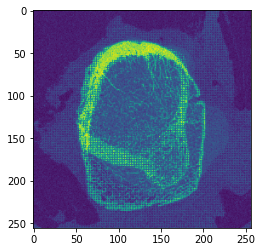

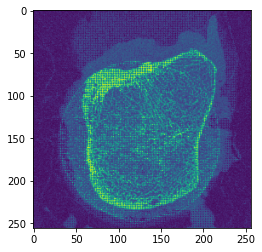

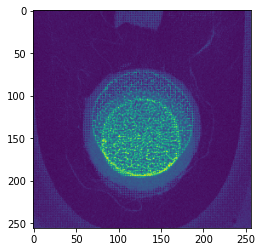

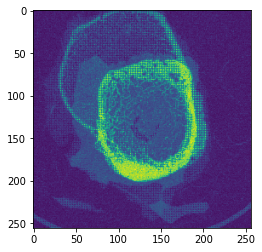

In [31]:
shape=256
print(seeded_images.shape)
print(all_images.shape)
testim = all_images.reshape(-1, 4, 1, shape, shape).permute(1, 0, 2, 3, 4).reshape(-1, 1, shape, shape)
testim = [img.permute(1, 2, 0).detach().cpu() for img in testim]

print(testim[0].shape)
ixs = [8, 17, 26, 35]
badimgs = [all_images[idx,:,:,:] for idx in ixs]
for idx in ixs:
    plt.imshow(testim[idx])
    plt.show()

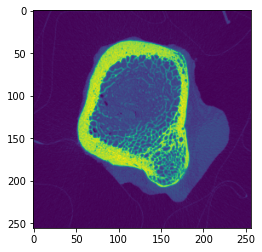

In [46]:
plt.imshow(testim[0])
plt.show()
p

In [33]:
from torch import nn
badimgs = [all_images[idx,:,:,:] for idx in ixs]
badimgs = torch.stack(badimgs,dim=0)
badimgs.shape

upmkr = nn.Upsample(size=None, scale_factor=2, mode='nearest', align_corners=None)
badimgs = upmkr(badimgs)
badimgs.shape

torch.Size([4, 1, 512, 512])

In [ ]:
mask = torch.full_like(badimgs, 0, dtype=bool)

# Random noise mask
# mask[torch.rand_like(seeded_images) < .3] = 1

#Make 1/2 res mask
divisor = 2
for i in range(int(mask.shape[2]/divisor)):
    for j in range(int(mask.shape[3]/divisor)):
        mask[:,:,i*divisor,j*divisor]=1
        
mask = mask.to(device)
mask.shape

# all_images_list = list(map(lambda n: trainer.ema_model.sample(256, batch_size=1, noise=seeded_images, mask=mask), [1]))
# all_images = torch.cat(all_images_list, dim=0)

In [10]:
#stage2 cascade
shape=512
# all_images_list = list(map(lambda n: trainer2.ema_model.sample(shape, batch_size=4, noise=badimgs, mask=mask), [4]))
all_images_list = list(map(lambda n: trainer2.ema_model.sample(shape, batch_size=4, noise=seeded_images, mask=mask), [4]))

all_images = torch.cat(all_images_list, dim=0)

sampling loop time step: 100%|██████████| 2000/2000 [14:06<00:00,  2.36it/s]


In [11]:
output_images = all_images.reshape(-1, 4, 1, shape, shape).permute(1, 0, 2, 3, 4).reshape(-1, 1, shape, shape)
output_images = [img.permute(1, 2, 0).detach().cpu() for img in output_images]

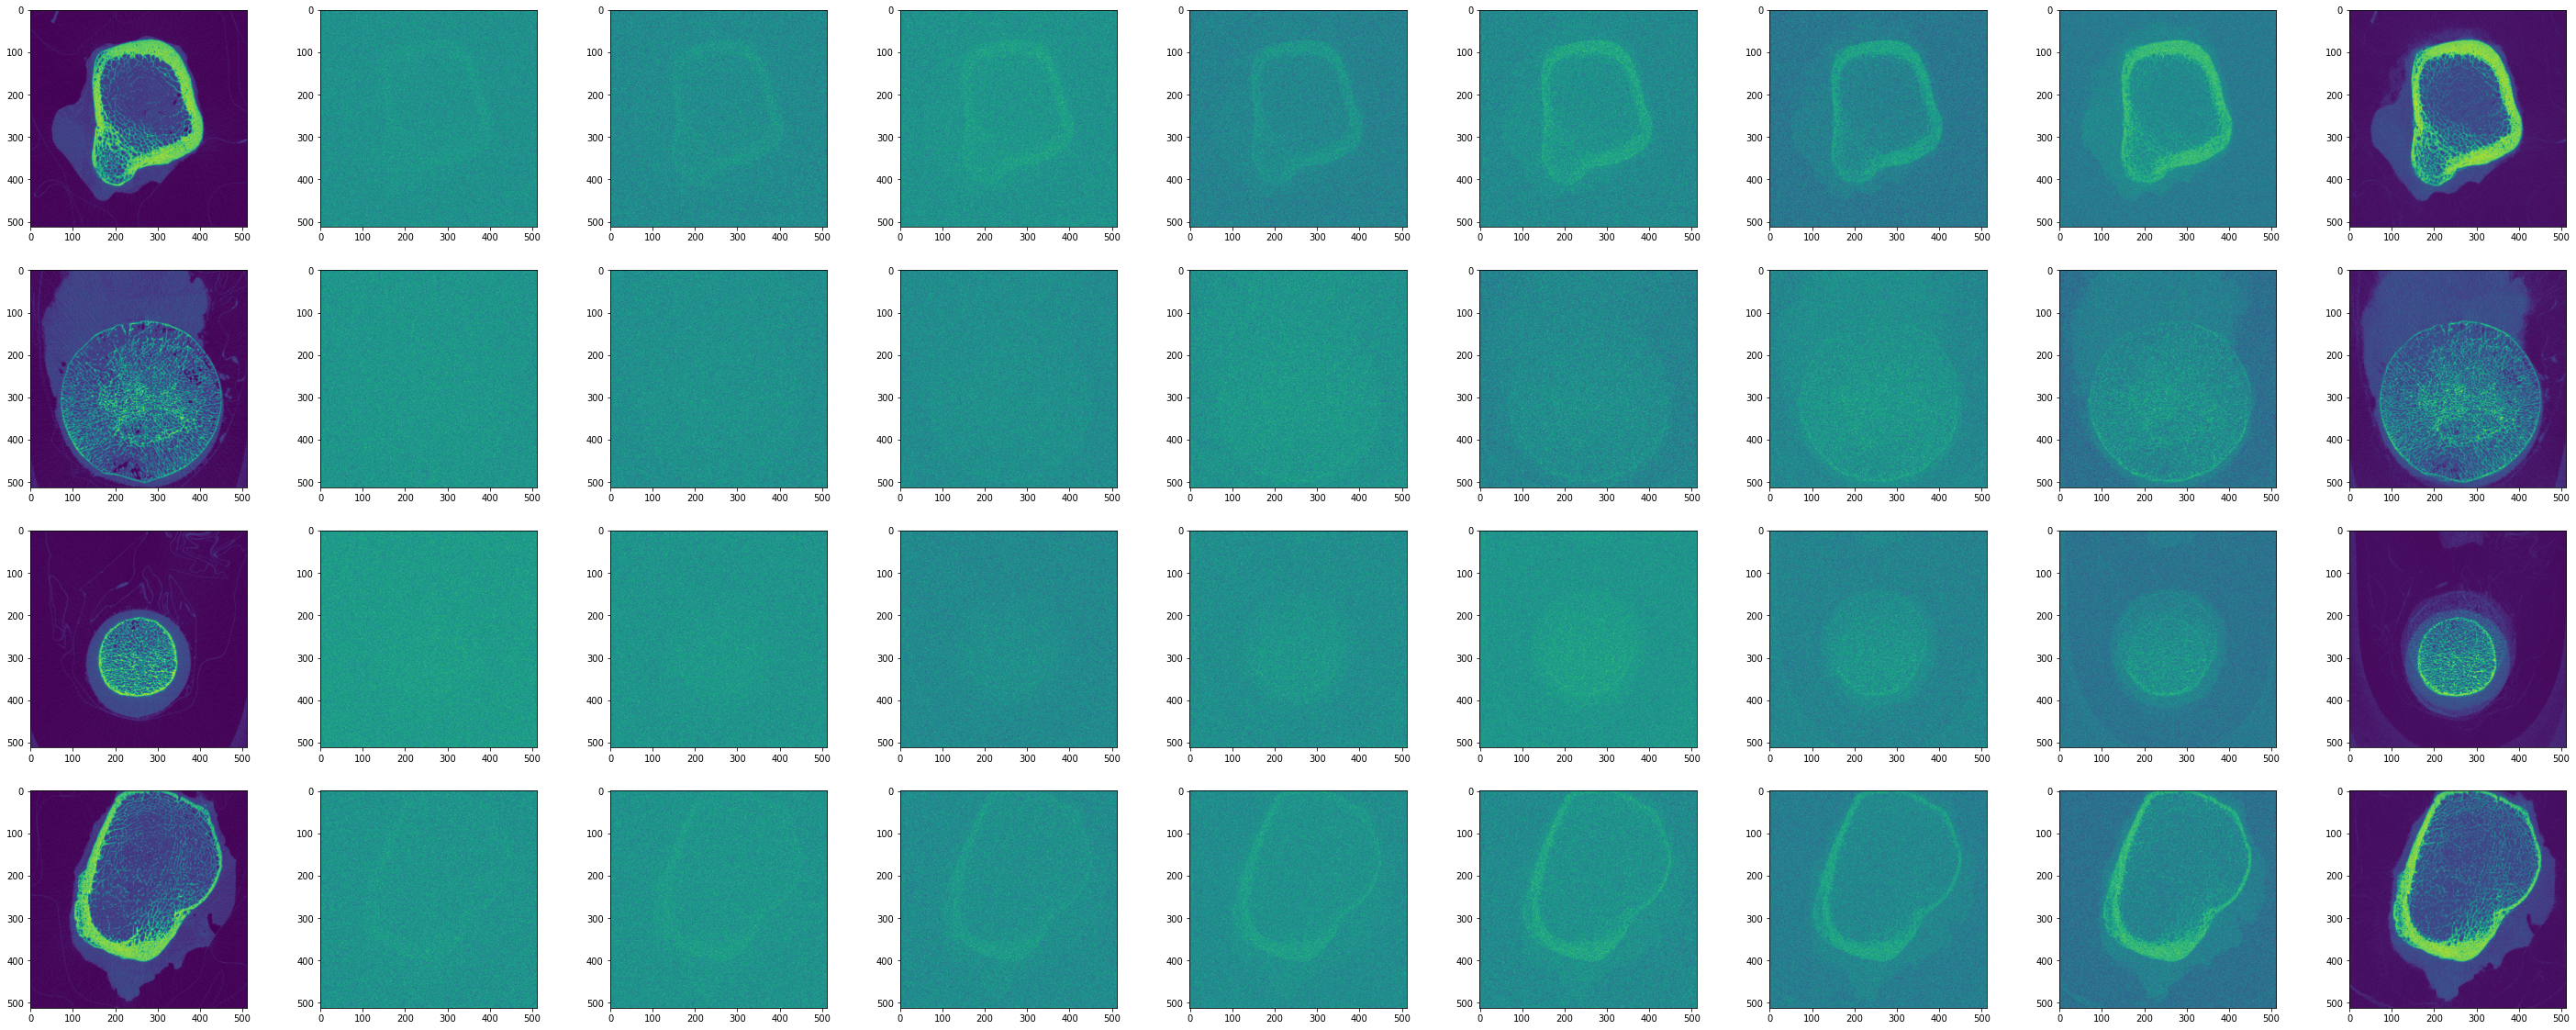

In [13]:
fig, axs = plt.subplots(4,9,figsize=(50,20))

for i,x in enumerate(output_images):
    axs[i//9,i%9].imshow(x)
plt.savefig("CT_conditioned_diffusion.png", format = 'png')

In [ ]:
for i in range(0,4):
    plt.imshow(np.bitwise_and(output_images[9*i + 8],mask)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


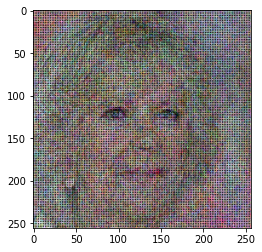

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


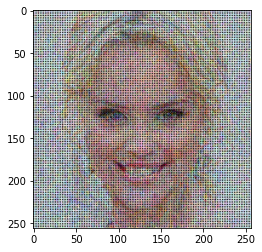

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


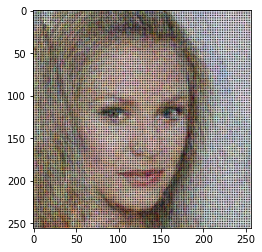

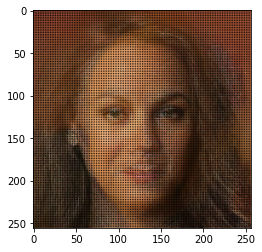

In [97]:
import numpy as np
for i in range(4):
    xx = output_images[9*i + 8].numpy() * np.invert(mask[0,:,:,:].permute(1,2,0).cpu().numpy())
    xx.shape
    plt.imshow(xx)
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'misc_outs/CT_in_gt_out_diff.png'

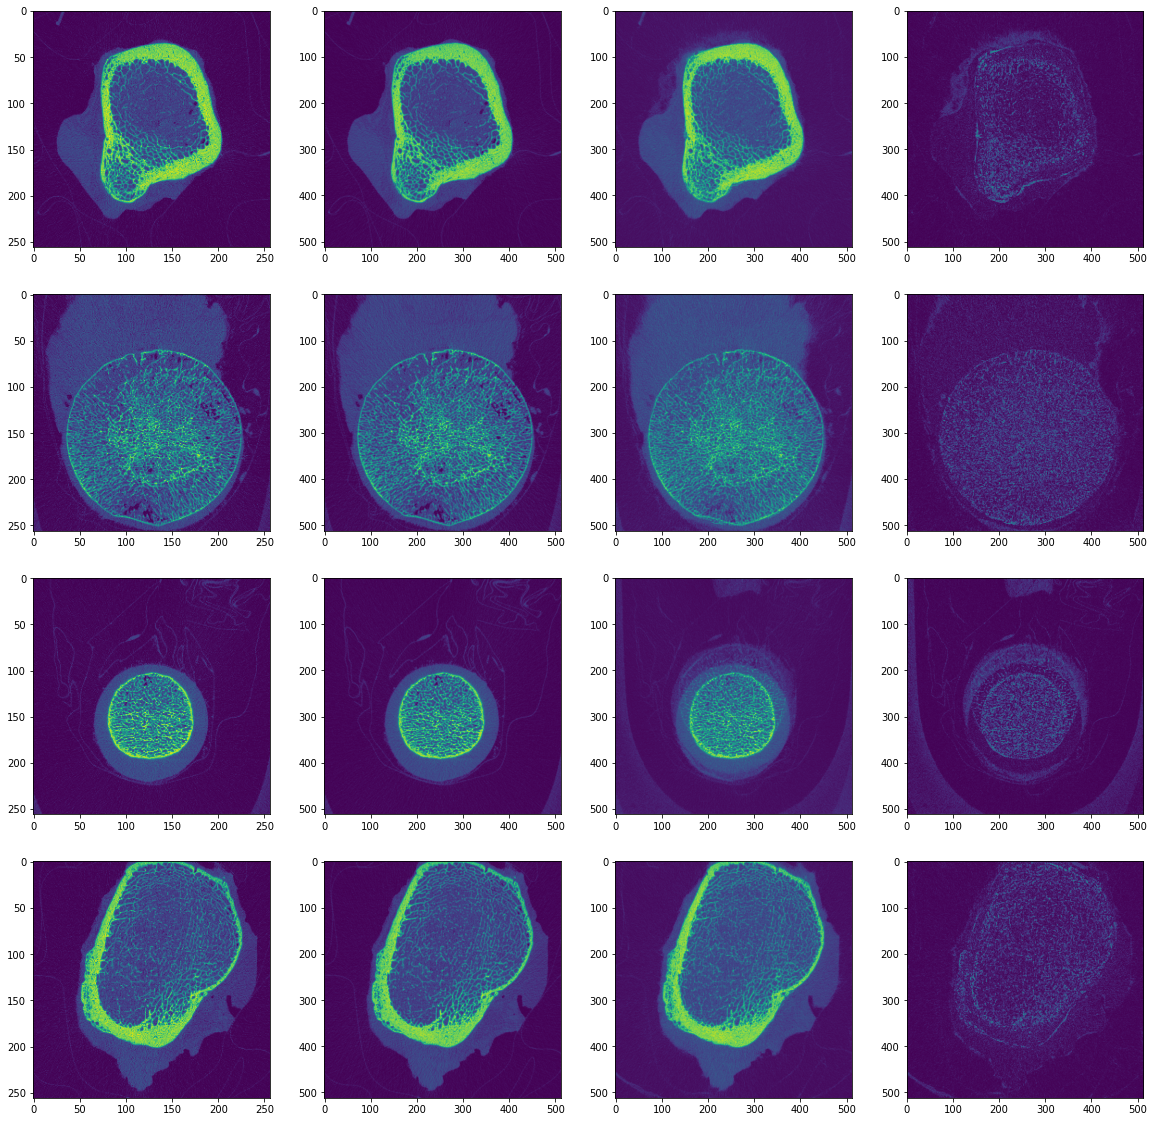

In [14]:
from torch import nn
fig, axs = plt.subplots(4,4,figsize=(20,20))

for i in range(0, 4):
    axs[i,0].imshow(output_images[9*i][0::divisor,0::divisor])
    axs[i,1].imshow(output_images[9*i])
    axs[i,2].imshow(output_images[9*i + 8])
    axs[i,3].imshow((output_images[9*i] - output_images[9*i + 8]).abs()*10)
plt.savefig("misc_CT_in_gt_out_diff.png", format = 'png')

In [ ]:
# Box mask
mask = torch.full_like(seeded_images, 1, dtype=bool)
_, _, h, w = mask.shape
mask[:, :, 0:h//2, :] = 0
# mask[:, :, h*30//100:h*52//100, w*17//100:w*83//100] = 0
# mask[:, :, h*30//100:h*52//100, w*42//100:w*58//100] = 1
# mask[:, :, h*20//100:h*80//100, w*20//100:w*80//100] = 0
# mask[:, :, h*30//100:h*70//100, w*30//100:w*70//100] = 1
# mask[:, :, h*40//100:h*60//100, w*40//100:w*60//100] = 0
# mask[:, :, h*45//100:h*55//100, w*45//100:w*55//100] = 1
# mask[:, :, h*25//100:h*75//100, w*24//100:w*75//100] = 1
mask = mask.to(device)
